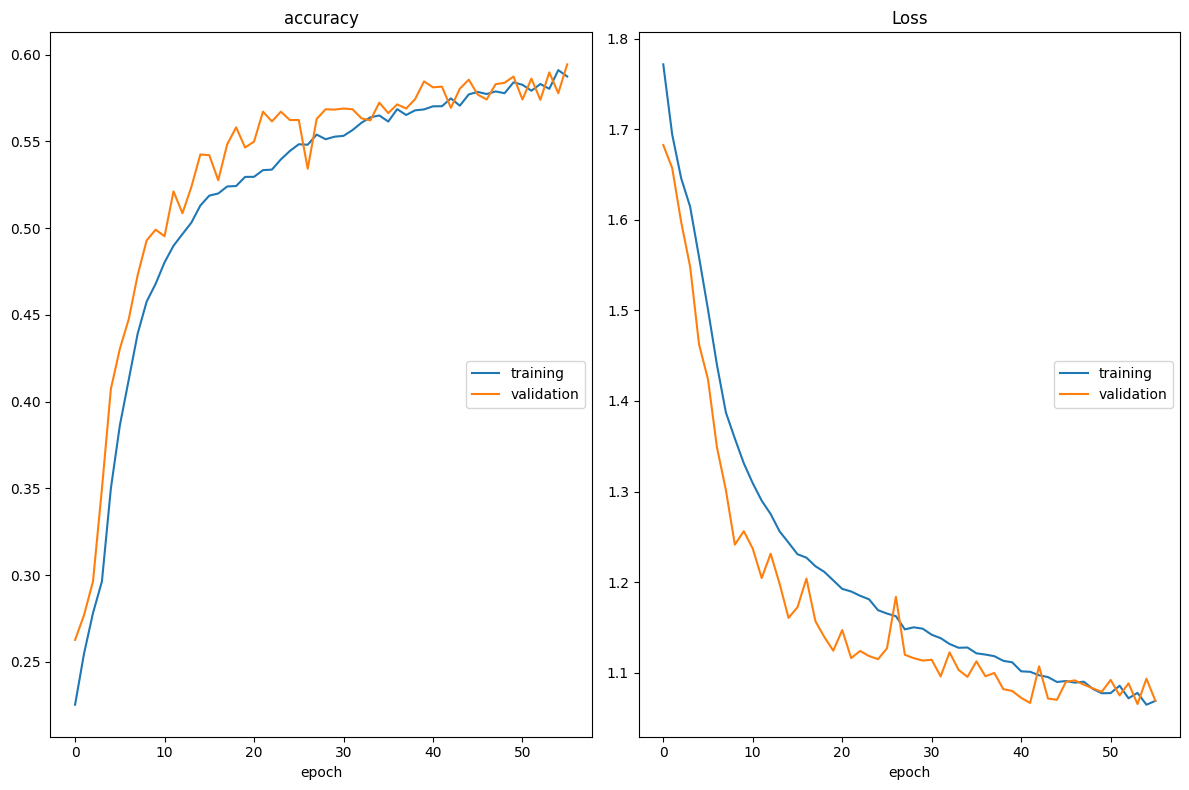

accuracy
	training         	 (min:    0.225, max:    0.591, cur:    0.587)
	validation       	 (min:    0.263, max:    0.594, cur:    0.594)
Loss
	training         	 (min:    1.065, max:    1.772, cur:    1.069)
	validation       	 (min:    1.065, max:    1.682, cur:    1.069)
595/595 [==============================] - 28s 46ms/step - loss: 1.0689 - accuracy: 0.5875 - val_loss: 1.0689 - val_accuracy: 0.5945


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# скачивание всего проекта
!wget https://github.com/gimaevra94/emotions_detector/archive/refs/heads/main.zip

# распаковка проекта
!unzip /content/main.zip

# распаковка данных
!unzip /content/emotions_detector-main/data.zip

# колбек рисующий график после каждой эпохи
!pip install livelossplot

# слои
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D

# колбек, оптимизатор, модель сети и препроцессинг
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# пути до папок
from pathlib import Path

# колбек рисующий график после каждой эпохи
from livelossplot import PlotLossesKeras

# пути до папок train и test. для clab и jupyter соответственно
path='content/'
path='C:/Users/gimaevra94/Documents/LocalHub/emotions_detector/data'

# создание каталогов под классы
base_dir=Path(path).parent/'data'
train_dir=base_dir/'train'
test_dir=base_dir/'test'

anger_dir=train_dir/'anger'
fear_dir=train_dir/'fear'
happy_dir=train_dir/'happy'
neutral_dir=train_dir/'neutral'
sad_dir=train_dir/'sad'
surprise_dir=train_dir/'surprise'

anger_dir=test_dir/'anger'
fear_dir=test_dir/'fear'
happy_dir=test_dir/'happy'
neutral_dir=test_dir/'neutral'
sad_dir=test_dir/'sad'
surprise_dir=train_dir/'surprise'

# генератор для train
train_gen=ImageDataGenerator(rotation_range=40,
                            fill_mode='nearest',
                            horizontal_flip=True,
                            rescale=1./255,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2)

# генератор для test
test_gen=ImageDataGenerator(rescale=1./255)

# изображения становятся одноканальными 80х80 с сохранением пропорций. перемешивается только train
train=train_gen.flow_from_directory(target_size=(80,80),
                                   color_mode='grayscale',
                                   class_mode='sparse',
                                   directory=train_dir)

test=test_gen.flow_from_directory(target_size=(80,80),
                                   color_mode='grayscale',
                                   class_mode='sparse',
                                   directory=test_dir,
                                    shuffle=False)

# модель сети
model=Sequential([
    Input((80,80,1)),
    BatchNormalization(),

    Conv2D(8,3,padding='same',activation='relu'),
    MaxPooling2D(2,None,'same'),
    BatchNormalization(),

    Conv2D(16,3,padding='same',activation='relu'),
    MaxPooling2D(2,None,'same'),
    BatchNormalization(),

    Conv2D(32,3,padding='same',activation='relu'),
    MaxPooling2D(2,None,'same'),
    BatchNormalization(),

    Conv2D(64,3,padding='same',activation='relu'),
    MaxPooling2D(2,None,'same'),
    BatchNormalization(),

    Conv2D(128,3,padding='same',activation='relu'),
    MaxPooling2D(2,None,'same'),
    BatchNormalization(),

    Conv2D(256,3,padding='same',activation='relu'),
    MaxPooling2D(2,None,'same'),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')])

# добавление в сеть ошибки, оптимизатора и метрики
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics='accuracy')

# ловит val_accuracy на >=59%, останавливает обучение и сохраняет модель
class MyCallback(Callback):
    def on_epoch_end(self,epoch,logs=None):
        val_accuracy=logs["val_accuracy"]
        if val_accuracy>=0.5900:
            self.model.stop_training=True
            self.model.save('model.h5')

# обучение
history=model.fit(x=train,
                    epochs=100,
                    validation_data=test,
                    batch_size=64,
                    callbacks=[PlotLossesKeras(),MyCallback()])